# Sistema de Recomendación (MovieLens)


Este notebook implementa un sistema híbrido de recomendaciones, con correcciones a problemas comunes en modelos Keras/Sklearn:

1. Carga y exploración de datos (MovieLens, subset de 1000 registros).  
2. Preparación de datos para Deep Learning (mapeo de IDs, matriz usuario-ítem).  
3. Entrenamiento de Autoencoder para ratings.  
4. Extracción de embeddings de usuarios.  
5. Recomendadores: colaborativo, contenido (TF-IDF) e híbrido.  
6. Ejemplos de recomendaciones.  
7. Evaluación con métricas Precision@K, Recall@K, NDCG@K.  


In [1]:

# Instalación de librerías necesarias (Colab)
!pip install surprise tensorflow scikit-learn matplotlib pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2610399 sha256=7ef0c33580417460dd1e215a6645bbab981050dc02f9b61c09ea2fe2a5053bf4
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


Shape: (1000, 4)
Usuarios únicos: 483
Películas únicas: 568


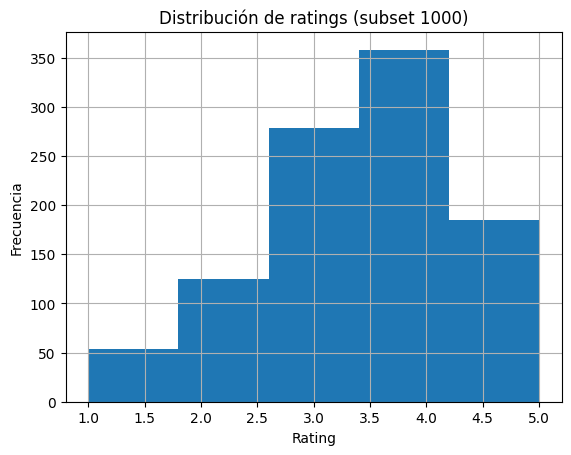

In [2]:

# ===============================
# 1. Carga y exploración de datos
# ===============================
import pandas as pd
import matplotlib.pyplot as plt

# Dataset MovieLens 100K (solo 1000 registros para práctica académica)
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
ratings = pd.read_csv(url, sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
ratings_small = ratings.sample(1000, random_state=42).reset_index(drop=True)

print("Shape:", ratings_small.shape)
print("Usuarios únicos:", ratings_small.user_id.nunique())
print("Películas únicas:", ratings_small.item_id.nunique())

# Distribución de ratings
ratings_small["rating"].hist(bins=5)
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.title("Distribución de ratings (subset 1000)")
plt.show()


In [3]:

# ===============================
# 2. Preparación de datos
# ===============================
import numpy as np
from sklearn.model_selection import train_test_split

n_users = ratings_small.user_id.nunique()
n_items = ratings_small.item_id.nunique()

# Mapear ids a índices consecutivos
user_mapping = {u:i for i,u in enumerate(ratings_small.user_id.unique())}
item_mapping = {m:i for i,m in enumerate(ratings_small.item_id.unique())}
ratings_small["user_idx"] = ratings_small.user_id.map(user_mapping)
ratings_small["item_idx"] = ratings_small.item_id.map(item_mapping)

# Matriz usuario-item
R = np.zeros((n_users, n_items))
for row in ratings_small.itertuples():
    R[row.user_idx, row.item_idx] = row.rating

# Split
train, test = train_test_split(ratings_small, test_size=0.2, random_state=42)
X_train, X_val = R, R  # autoencoder reconstruye entradas


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2782 - val_loss: 0.2527
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2426 - val_loss: 0.2110
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2003 - val_loss: 0.1652
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1551 - val_loss: 0.1253
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1182 - val_loss: 0.0972
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0926 - val_loss: 0.0799
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0769 - val_loss: 0.0693
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0685 - val_loss: 0.0629
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0608 - val_loss: 0.0589
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0576 - val_loss: 0.0563
Epoch 11/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0555 - val_loss: 0.0546
Epoch 12/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0543 - val_

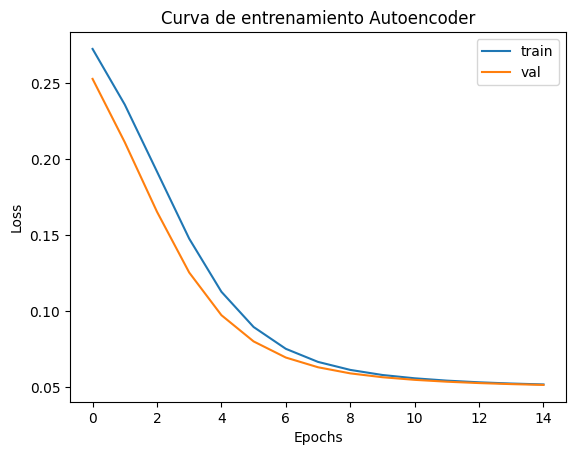

In [4]:

# ===============================
# 3. Autoencoder para ratings
# ===============================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim = n_items
encoding_dim = 64

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train, X_train,
    epochs=15,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1
)

# Curva de pérdida
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Curva de entrenamiento Autoencoder")
plt.show()


In [5]:

# ===============================
# 4. Embeddings de usuarios
# ===============================
encoder = keras.Model(input_layer, encoded)
user_embeddings = encoder.predict(R)
print("Embeddings de usuarios:", user_embeddings.shape)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Embeddings de usuarios: (483, 64)


In [6]:

# ===============================
# 5. Sistema de contenido (TF-IDF)
# ===============================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Metadatos de películas
movies_url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.item"
movies = pd.read_csv(movies_url, sep="|", encoding="latin-1", header=None)
movies = movies[[0, 1]]
movies.columns = ["item_id", "title"]

# TF-IDF sobre títulos
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies["title"].fillna(""))
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Matriz de similitud de contenido:", cosine_sim.shape)


Matriz de similitud de contenido: (1682, 1682)


In [7]:

# ===============================
# 6. Funciones de recomendación
# ===============================
def recommend_collab_for_user(user_id, top_k=5):
    idx = user_mapping.get(user_id, None)
    if idx is None:
        return pd.DataFrame()
    preds = autoencoder.predict(R)
    scores = preds[idx]
    top_items = scores.argsort()[::-1][:top_k]
    recs = movies.iloc[top_items][["item_id","title"]].copy()
    recs["score"] = scores[top_items]
    return recs

def recommend_content_for_user(user_id, top_k=5):
    seen_items = ratings_small[ratings_small.user_id == user_id].item_id.unique()
    if len(seen_items) == 0:
        return pd.DataFrame()
    ref_item = seen_items[0]
    sims = cosine_sim[item_mapping[ref_item]]
    idxs = sims.argsort()[::-1][1:top_k+1]
    recs = movies.iloc[idxs][["item_id","title"]].copy()
    recs["score"] = sims[idxs]
    return recs

def recommend_hybrid(user_id, alpha=0.5, top_k=5):
    collab = recommend_collab_for_user(user_id, top_k=top_k*2)
    content = recommend_content_for_user(user_id, top_k=top_k*2)
    if collab.empty or content.empty:
        return pd.DataFrame()
    merged = pd.merge(collab, content, on=["item_id","title"], how="outer", suffixes=("_c","_t")).fillna(0)
    merged["hybrid_score"] = alpha*merged["score_c"] + (1-alpha)*merged["score_t"]
    recs = merged.sort_values("hybrid_score", ascending=False).head(top_k)
    return recs.reset_index(drop=True)


In [8]:

# ===============================
# 7. Ejemplo de recomendaciones
# ===============================
sample_users = ratings_small.user_id.sample(2, random_state=42)
for u in sample_users:
    print(f"\nUsuario {u}")
    print("Colaborativo:")
    display(recommend_collab_for_user(u, top_k=5))
    print("Contenido:")
    display(recommend_content_for_user(u, top_k=5))
    print("Híbrido:")
    display(recommend_hybrid(u, alpha=0.6, top_k=5))



Usuario 600
Colaborativo:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,item_id,title,score
92,93,Welcome to the Dollhouse (1995),0.114335
76,77,"Firm, The (1993)",0.103981
91,92,True Romance (1993),0.102266
37,38,"Net, The (1995)",0.100373
53,54,Outbreak (1995),0.096399


Contenido:


,item_id,title,score
40,41,Billy Madison (1995),0.413649
1052,1053,Now and Then (1995),0.203335
1546,1547,"Show, The (1995)",0.203335
1589,1590,"To Have, or Not (1995)",0.203335
722,723,Boys on the Side (1995),0.082887


Híbrido:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,item_id,title,score_c,score_t,hybrid_score
0,41,Billy Madison (1995),0.000000,0.413649,0.165460
1,1053,Now and Then (1995),0.000000,0.203335,0.081334
2,1590,"To Have, or Not (1995)",0.000000,0.203335,0.081334
3,1547,"Show, The (1995)",0.000000,0.203335,0.081334
4,93,Welcome to the Dollhouse (1995),0.114335,0.000000,0.068601



Usuario 751
Colaborativo:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,item_id,title,score
92,93,Welcome to the Dollhouse (1995),0.035254
76,77,"Firm, The (1993)",0.028638
101,102,"Aristocats, The (1970)",0.026523
249,250,"Fifth Element, The (1997)",0.024635
519,520,"Great Escape, The (1963)",0.024503


Contenido:


,item_id,title,score
274,275,Sense and Sensibility (1995),0.349786
1293,1294,Ayn Rand: A Sense of Life (1997),0.309423
98,99,Snow White and the Seven Dwarfs (1937),0.259874
1537,1538,All Over Me (1997),0.226083
1527,1528,Nowhere (1997),0.226083


Híbrido:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,item_id,title,score_c,score_t,hybrid_score
0,275,Sense and Sensibility (1995),0.0,0.349786,0.139915
1,1294,Ayn Rand: A Sense of Life (1997),0.0,0.309423,0.123769
2,99,Snow White and the Seven Dwarfs (1937),0.0,0.259874,0.103950
3,301,In & Out (1997),0.0,0.226083,0.090433
4,1528,Nowhere (1997),0.0,0.226083,0.090433


In [9]:

# ===============================
# 8. Evaluación de métricas
# ===============================
def precision_recall_ndcg(user_id, k=10, alpha=0.5):
    mapped_idx = user_mapping.get(user_id, None)
    if mapped_idx is None:
        return None

    true_items = np.asarray(R[mapped_idx]).ravel()
    R_pred = autoencoder.predict(R)
    pred_scores = np.asarray(R_pred[mapped_idx]).ravel()

    if true_items.sum() == 0:
        return None

    top_k_items = pred_scores.argsort()[::-1][:k]
    relevant = set(np.where(true_items > 0)[0])
    recommended = set(top_k_items)

    tp = len(relevant & recommended)
    precision = tp / k
    recall = tp / len(relevant) if len(relevant) > 0 else 0

    dcg = sum([1/np.log2(i+2) for i, idx in enumerate(top_k_items) if idx in relevant])
    idcg = sum([1/np.log2(i+2) for i in range(min(len(relevant), k))])
    ndcg = dcg / idcg if idcg > 0 else 0

    return precision, recall, ndcg

# Evaluación sobre usuarios de test
K = 5
precisions, recalls, ndcgs = [], [], []
for u in test.user_id.unique():
    vals = precision_recall_ndcg(u, k=K)
    if vals is None: continue
    p,r,n = vals
    precisions.append(p)
    recalls.append(r)
    ndcgs.append(n)

print("Precision@K:", np.mean(precisions))
print("Recall@K:", np.mean(recalls))
print("NDCG@K:", np.mean(ndcgs))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
